<a href="https://colab.research.google.com/github/kumar-devesh/DETR/blob/master/notebooks/dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import itertools
import PIL
import torch
from tqdm import tqdm
from shutil import copyfile
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from torchvision.datasets import VOCDetection

In [1]:
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.utils import draw_bounding_boxes

In [3]:
!pip install xmltodict
!pip install dicttoxml 

  Created wheel for dicttoxml: filename=dicttoxml-1.7.4-py3-none-any.whl size=17463 sha256=d09770dfc5b45f5a43c36c0ea53287ec35a1b886dddfa4648808fb376fec1c9f
  Stored in directory: /root/.cache/pip/wheels/18/44/5a/c7b93703f611ae3b50820efbaf265413e6b183a56cbec6f661
Successfully built dicttoxml


In [4]:
import xmltodict
from dicttoxml import dicttoxml
from xml.dom.minidom import parseString

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
batch_size = 1
dir_path = "/content/drive/MyDrive/Colab Notebooks/detr"

In [7]:
os.chdir(dir_path)

In [8]:
!mkdir -p ./dataset

In [9]:
os.listdir("./dataset")

['VOCtrainval_11-May-2012.tar', 'VOCdevkit', 'preprocessed', 'processed']

In [10]:
if len(os.listdir("./dataset")) != 0:
  train_data = VOCDetection(root = os.path.join(dir_path, 'dataset'), image_set = 'train', download = False, transform = transforms.ToTensor())
else:
  train_data = VOCDetection(root = os.path.join(dir_path, 'dataset'), image_set = 'train', download = True, transform = transforms.ToTensor())

In [11]:
img_dir_raw = os.path.join(dir_path, 'dataset/VOCdevkit/VOC2012/JPEGImages')
annotation_dir_raw = os.path.join(dir_path, 'dataset/VOCdevkit/VOC2012/Annotations')

In [12]:
img_dir_preprocessed = os.path.join(dir_path, 'dataset/preprocessed/images')
annotation_dir_preprocessed = os.path.join(dir_path, 'dataset/preprocessed/annotations')

### make directories

In [13]:
#create 3 directories for images and annotations train,test,val

In [14]:
!mkdir -p dataset/preprocessed/images/train
!mkdir -p dataset/preprocessed/images/test
!mkdir -p dataset/preprocessed/images/val
!mkdir -p dataset/preprocessed/annotations/train
!mkdir -p dataset/preprocessed/annotations/test
!mkdir -p dataset/preprocessed/annotations/val
!mkdir -p dataset/processed/images/train
!mkdir -p dataset/processed/annotations/train
!mkdir -p dataset/processed/images/val
!mkdir -p dataset/processed/annotations/val
!mkdir -p dataset/processed/images/test
!mkdir -p dataset/processed/annotations/test

### dataset visualization


In [15]:
train_loader = DataLoader(train_data, batch_size, shuffle=True, num_workers=2)

In [16]:
img, labels = next(iter(train_loader))

In [17]:
def plotImage(image):
  image = np.array(image)
  plt.imshow(np.transpose(image,(1,2,0)))

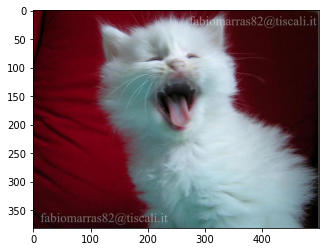

In [18]:
plotImage(img[0])

In [54]:
#sample dictionary
xml_path = os.path.join(dir_path, 'dataset/preprocessed/annotations/train/2008_000036.xml')
img_path = os.path.join(dir_path, 'dataset/preprocessed/images/train/2008_000036.jpg')

In [55]:
dct = convert_xml_to_dict(xml_path)

In [56]:
print(dct)

OrderedDict([('annotation', OrderedDict([('folder', 'VOC2012'), ('filename', '2008_000036.jpg'), ('source', OrderedDict([('database', 'The VOC2008 Database'), ('annotation', 'PASCAL VOC2008'), ('image', 'flickr')])), ('size', OrderedDict([('width', '500'), ('height', '375'), ('depth', '3')])), ('segmented', '0'), ('object', [OrderedDict([('name', 'bicycle'), ('pose', 'Left'), ('truncated', '1'), ('occluded', '0'), ('bndbox', OrderedDict([('xmin', '120'), ('ymin', '1'), ('xmax', '203'), ('ymax', '35')])), ('difficult', '0')]), OrderedDict([('name', 'bicycle'), ('pose', 'Left'), ('truncated', '1'), ('occluded', '1'), ('bndbox', OrderedDict([('xmin', '117'), ('ymin', '38'), ('xmax', '273'), ('ymax', '121')])), ('difficult', '0')]), OrderedDict([('name', 'person'), ('pose', 'Left'), ('truncated', '0'), ('occluded', '0'), ('bndbox', OrderedDict([('xmin', '206'), ('ymin', '74'), ('xmax', '395'), ('ymax', '237')])), ('difficult', '0'), ('part', [OrderedDict([('name', 'head'), ('bndbox', Order

In [57]:
dct_annotation = dct['annotation']
dct_annotation['size']

OrderedDict([('width', '500'), ('height', '375'), ('depth', '3')])

In [58]:
dct_object_list = dct_annotation['object']

In [59]:
bndbox_list = []
name_list = []

In [60]:
# dct object can be a dictionary or list of dictionaries
for dct_object in dct_object_list:
  dct_bndbox = dct_object['bndbox']
  bndbox_list.append([int(dct_bndbox['xmin']), int(dct_bndbox['ymin']), int(dct_bndbox['xmax']), int(dct_bndbox['ymax'])])
  name = dct_object['name']
  name_list.append(name)
  print(dct_bndbox)

OrderedDict([('xmin', '120'), ('ymin', '1'), ('xmax', '203'), ('ymax', '35')])
OrderedDict([('xmin', '117'), ('ymin', '38'), ('xmax', '273'), ('ymax', '121')])
OrderedDict([('xmin', '206'), ('ymin', '74'), ('xmax', '395'), ('ymax', '237')])
OrderedDict([('xmin', '24'), ('ymin', '2'), ('xmax', '500'), ('ymax', '188')])
OrderedDict([('xmin', '1'), ('ymin', '187'), ('xmax', '500'), ('ymax', '282')])


In [61]:
image = Image.open(img_path)
bndbox_list = np.array(bndbox_list)
name_list = np.array(name_list)
image = np.array(image)
image = np.transpose(image, (2,0,1))

In [62]:
result = draw_bounding_boxes(image = torch.tensor(image), boxes = torch.from_numpy(bndbox_list),labels = name_list, width=5)
result = np.array(result)
print(result.shape)

(3, 375, 500)


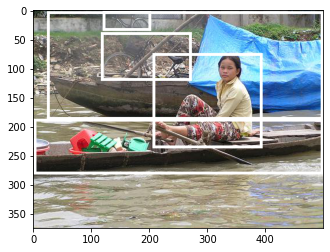

In [63]:
result = np.transpose(result, (1,2,0))
plt.imshow(result)

### dataset analysis

In [19]:
def plotGrid(train_images):
  images = train_images
  img_grid = torchvision.utils.make_grid(images, nrow=4)
  img_grig = np.array(img_grid)
  img_grid = np.transpose(img_grid,(1,2,0))
  plt.imshow(img_grid)

In [20]:
def convert_xml_to_dict(path):
  """ converts xml file to a dictionary """
  fileptr = open(path,"r")
 
  xml = fileptr.read()
  
  #change xml format to ordered dict
  xml_to_dict = xmltodict.parse(xml)
  return xml_to_dict

In [21]:
def convert_dict_to_xml(inp_dict):
  """ convets dictionary to xml """
  xml = dicttoxml(inp_dict)
  return xml

In [22]:
img_raw_list = os.listdir(img_dir_raw)
annotation_raw_list = os.listdir(annotation_dir_raw)

In [23]:
img_raw_list.sort(reverse = True)
annotation_raw_list.sort(reverse = True)

In [24]:
print(img_raw_list[0:8])
print(annotation_raw_list[0:8])

['2012_004331.jpg', '2012_004330.jpg', '2012_004329.jpg', '2012_004328.jpg', '2012_004326.jpg', '2012_004319.jpg', '2012_004317.jpg', '2012_004315.jpg']
['2012_004331.xml', '2012_004330.xml', '2012_004329.xml', '2012_004328.xml', '2012_004326.xml', '2012_004319.xml', '2012_004317.xml', '2012_004315.xml']


In [25]:
print(len(img_raw_list))
print(len(annotation_raw_list))

17125
17125


In [26]:
path = './dataset/VOCdevkit/VOC2012/Annotations/2012_004331.xml'
dct = convert_xml_to_dict(path)
print(dct)

OrderedDict([('annotation', OrderedDict([('filename', '2012_004331.jpg'), ('folder', 'VOC2012'), ('object', OrderedDict([('name', 'person'), ('actions', OrderedDict([('jumping', '1'), ('other', '0'), ('phoning', '0'), ('playinginstrument', '0'), ('reading', '0'), ('ridingbike', '0'), ('ridinghorse', '0'), ('running', '0'), ('takingphoto', '0'), ('usingcomputer', '0'), ('walking', '0')])), ('bndbox', OrderedDict([('xmax', '208'), ('xmin', '102'), ('ymax', '230'), ('ymin', '25')])), ('difficult', '0'), ('pose', 'Unspecified'), ('point', OrderedDict([('x', '155'), ('y', '119')]))])), ('segmented', '0'), ('size', OrderedDict([('depth', '3'), ('height', '375'), ('width', '500')])), ('source', OrderedDict([('annotation', 'PASCAL VOC2012'), ('database', 'The VOC2012 Database'), ('image', 'flickr')]))]))])


In [27]:
xml = convert_dict_to_xml(dct)
print(xml)

b'<?xml version="1.0" encoding="UTF-8" ?><root><annotation type="dict"><filename type="str">2012_004331.jpg</filename><folder type="str">VOC2012</folder><object type="dict"><name type="str">person</name><actions type="dict"><jumping type="str">1</jumping><other type="str">0</other><phoning type="str">0</phoning><playinginstrument type="str">0</playinginstrument><reading type="str">0</reading><ridingbike type="str">0</ridingbike><ridinghorse type="str">0</ridinghorse><running type="str">0</running><takingphoto type="str">0</takingphoto><usingcomputer type="str">0</usingcomputer><walking type="str">0</walking></actions><bndbox type="dict"><xmax type="str">208</xmax><xmin type="str">102</xmin><ymax type="str">230</ymax><ymin type="str">25</ymin></bndbox><difficult type="str">0</difficult><pose type="str">Unspecified</pose><point type="dict"><x type="str">155</x><y type="str">119</y></point></object><segmented type="str">0</segmented><size type="dict"><depth type="str">3</depth><height typ

In [28]:
def get_data():
  images = []
  annotations = []
  for image_file in img_raw_list[0:8]:
    img_path = os.path.join(img_dir_raw, image_file)
    image = np.array(Image.open(img_path))
    images.append(image)
  for annotation_file in annotation_raw_list[0:8]:
    annotation_path = os.path.join(annotation_dir_raw, annotation_file)
    annotation = convert_xml_to_dict(annotation_path)
    annotations.append(annotation)
  return (images, annotations)

In [29]:
images, annotations = get_data()

In [30]:
print(annotations[0])

OrderedDict([('annotation', OrderedDict([('filename', '2012_004331.jpg'), ('folder', 'VOC2012'), ('object', OrderedDict([('name', 'person'), ('actions', OrderedDict([('jumping', '1'), ('other', '0'), ('phoning', '0'), ('playinginstrument', '0'), ('reading', '0'), ('ridingbike', '0'), ('ridinghorse', '0'), ('running', '0'), ('takingphoto', '0'), ('usingcomputer', '0'), ('walking', '0')])), ('bndbox', OrderedDict([('xmax', '208'), ('xmin', '102'), ('ymax', '230'), ('ymin', '25')])), ('difficult', '0'), ('pose', 'Unspecified'), ('point', OrderedDict([('x', '155'), ('y', '119')]))])), ('segmented', '0'), ('size', OrderedDict([('depth', '3'), ('height', '375'), ('width', '500')])), ('source', OrderedDict([('annotation', 'PASCAL VOC2012'), ('database', 'The VOC2012 Database'), ('image', 'flickr')]))]))])


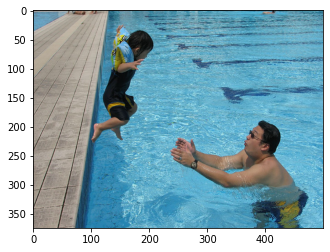

In [31]:
plt.imshow(images[0])

### preprocessing


use a train val split

In [32]:
split_path = '/content/drive/MyDrive/Colab Notebooks/detr/dataset/VOCdevkit/VOC2012/ImageSets/Main'

In [33]:
os.listdir(split_path)

['train.txt',
 'val.txt',
 'trainval.txt',
 'aeroplane_train.txt',
 'bicycle_train.txt',
 'bird_train.txt',
 'boat_train.txt',
 'bus_train.txt',
 'bottle_train.txt',
 'car_train.txt',
 'cat_train.txt',
 'chair_train.txt',
 'cow_train.txt',
 'diningtable_train.txt',
 'dog_train.txt',
 'horse_train.txt',
 'motorbike_train.txt',
 'person_train.txt',
 'pottedplant_train.txt',
 'sheep_train.txt',
 'sofa_train.txt',
 'train_train.txt',
 'aeroplane_val.txt',
 'tvmonitor_train.txt',
 'bicycle_val.txt',
 'bird_val.txt',
 'boat_val.txt',
 'bottle_val.txt',
 'car_val.txt',
 'bus_val.txt',
 'cat_val.txt',
 'cow_val.txt',
 'chair_val.txt',
 'diningtable_val.txt',
 'horse_val.txt',
 'dog_val.txt',
 'motorbike_val.txt',
 'person_val.txt',
 'pottedplant_val.txt',
 'sheep_val.txt',
 'sofa_val.txt',
 'train_val.txt',
 'tvmonitor_val.txt',
 'aeroplane_trainval.txt',
 'bicycle_trainval.txt',
 'bird_trainval.txt',
 'boat_trainval.txt',
 'bottle_trainval.txt',
 'bus_trainval.txt',
 'car_trainval.txt',
 'cat

In [34]:
train_file_path = os.path.join(split_path, 'train.txt')
val_file_path = os.path.join(split_path, 'val.txt')

In [35]:
train_list = []

In [36]:
with open(train_file_path, mode = 'r') as f:
  for line in f:
    line = line.rstrip()
    train_list.append(line)

In [37]:
print(len(train_list))

5717


In [38]:
print(train_list)

['2008_000008', '2008_000015', '2008_000019', '2008_000023', '2008_000028', '2008_000033', '2008_000036', '2008_000037', '2008_000041', '2008_000045', '2008_000053', '2008_000060', '2008_000066', '2008_000070', '2008_000074', '2008_000085', '2008_000089', '2008_000093', '2008_000095', '2008_000096', '2008_000097', '2008_000099', '2008_000103', '2008_000105', '2008_000109', '2008_000112', '2008_000128', '2008_000131', '2008_000132', '2008_000141', '2008_000142', '2008_000143', '2008_000144', '2008_000148', '2008_000151', '2008_000154', '2008_000162', '2008_000176', '2008_000181', '2008_000185', '2008_000187', '2008_000188', '2008_000189', '2008_000191', '2008_000192', '2008_000193', '2008_000196', '2008_000197', '2008_000199', '2008_000202', '2008_000207', '2008_000217', '2008_000226', '2008_000227', '2008_000235', '2008_000236', '2008_000237', '2008_000238', '2008_000252', '2008_000255', '2008_000259', '2008_000260', '2008_000262', '2008_000266', '2008_000273', '2008_000275', '2008_000

In [39]:
val_list = []

In [40]:
with open(val_file_path, mode = 'r') as f:
  for line in f:
    line = line.rstrip()
    val_list.append(line)

In [41]:
print(len(val_list))

5823


In [42]:
print(val_list)

['2008_000002', '2008_000003', '2008_000007', '2008_000009', '2008_000016', '2008_000021', '2008_000026', '2008_000027', '2008_000032', '2008_000034', '2008_000042', '2008_000043', '2008_000050', '2008_000051', '2008_000052', '2008_000054', '2008_000056', '2008_000059', '2008_000062', '2008_000064', '2008_000067', '2008_000073', '2008_000075', '2008_000076', '2008_000078', '2008_000080', '2008_000082', '2008_000084', '2008_000090', '2008_000107', '2008_000115', '2008_000116', '2008_000119', '2008_000120', '2008_000123', '2008_000133', '2008_000134', '2008_000138', '2008_000140', '2008_000145', '2008_000149', '2008_000163', '2008_000174', '2008_000177', '2008_000182', '2008_000183', '2008_000190', '2008_000194', '2008_000195', '2008_000203', '2008_000204', '2008_000213', '2008_000215', '2008_000219', '2008_000222', '2008_000223', '2008_000233', '2008_000234', '2008_000239', '2008_000243', '2008_000244', '2008_000246', '2008_000251', '2008_000253', '2008_000254', '2008_000257', '2008_000

### mov the files into corresponding folders

In [ ]:
train_list.sort(reverse = True)
val_list.sort(reverse = True)

In [ ]:
print(len(train_list))
print(len(val_list))

5717
5823


In [ ]:
def copy_to_train():
  for image in train_list:
    img_path_src = os.path.join(img_dir_raw, image)
    img_path_src = img_path_src + '.jpg' #extension
    img_path_dst = os.path.join(img_dir_preprocessed, 'train', image)
    img_path_dst = img_path_dst + '.jpg' #extension
    img = Image.open(img_path_src)
    img = img.save(img_path_dst)

  for annotation in train_list:
    annotation_path_src = os.path.join(annotation_dir_raw, annotation)
    annotation_path_src = annotation_path_src + '.xml' #extension
    annotation_path_dst = os.path.join(annotation_dir_preprocessed, 'train', annotation)
    annotation_path_dst = annotation_path_dst + '.xml' #extension
    copyfile(annotation_path_src, annotation_path_dst)

In [ ]:
def copy_to_val():
  for image in val_list:
    img_path_src = os.path.join(img_dir_raw, image)
    img_path_src = img_path_src + '.jpg' #extension
    img_path_dst = os.path.join(img_dir_preprocessed, 'val', image)
    img_path_dst = img_path_dst + '.jpg' #extension
    img = Image.open(img_path_src)
    img = img.save(img_path_dst)

  for annotation in val_list:
    annotation_path_src = os.path.join(annotation_dir_raw, annotation)
    annotation_path_src = annotation_path_src + '.xml' #extension
    annotation_path_dst = os.path.join(annotation_dir_preprocessed, 'val', annotation)
    annotation_path_dst = annotation_path_dst + '.xml' #extension
    copyfile(annotation_path_src, annotation_path_dst)

In [ ]:
copy_to_val()
copy_to_train()

### resize image files and annotations

In [43]:
train_img_list = os.listdir(os.path.join(img_dir_preprocessed, 'train'))
val_img_list = os.listdir(os.path.join(img_dir_preprocessed, 'val'))

In [44]:
train_annotation_list = os.listdir(os.path.join(annotation_dir_preprocessed, 'train'))
val_annotation_list = os.listdir(os.path.join(annotation_dir_preprocessed, 'val'))

In [149]:
def resize_images(img_list, src_dir, tgt_dir):
  for image in img_list:
    src_img_path = os.path.join(src_dir, image)
    img = Image.open(src_img_path)
    tgt_img_path = os.path.join(tgt_dir, image)
    img = img.resize((256, 256), PIL.Image.BILINEAR)
    img = img.save(tgt_img_path)

In [150]:
resize_images(img_list=train_img_list, src_dir=os.path.join(img_dir_preprocessed, 'train'), tgt_dir = os.path.join(dir_path, 'dataset/processed/images/train'))
resize_images(img_list=val_img_list, src_dir=os.path.join(img_dir_preprocessed, 'val'), tgt_dir = os.path.join(dir_path, 'dataset/processed/images/val'))

In [46]:
def resize_box(dct, img_size):
  y_scale = 256/int(img_size['height'])
  x_scale = 256/int(img_size['width'])
  dct['xmin'] = int(dct['xmin'])*x_scale
  dct['xmax'] = int(dct['xmax'])*x_scale
  dct['ymin'] = int(dct['ymin'])*y_scale
  dct['ymax'] = int(dct['ymax'])*y_scale
  return dct

In [47]:
def save_xml(xml, path):
  #open text file
  dom = parseString(xml)
  text_file = open(path, "w")

  #write string to file
  text_file.write(dom.toprettyxml())
  
  #close file
  text_file.close()

In [153]:
def resize_annotations(annotation_list, src_dir, tgt_dir):
  for annotation in annotation_list:
    src_annotation_path = os.path.join(src_dir, annotation)
    dct = convert_xml_to_dict(src_annotation_path)

    dct_annotation = dct['annotation']
    dct_object_list = dct_annotation['object']

    # value is a dictionary for single object in images and is a list of dictionaries for multiple objects
    if isinstance(dct_object_list, dict):
      temp =[]
      temp.append(dct_object_list)
      dct_object_list = temp
    
    dct_list=[]
    for dct_object in dct_object_list:
      dct_bndbox = dct_object['bndbox']
      dct_bndbox = resize_box(dct_bndbox, dct_annotation['size'])
      dct_object['bndbox'] = dct_bndbox
      dct_list.append(dct_object)

    dct['annotation']['object'] = dct_list
    xml = convert_dict_to_xml(dct)

    tgt_annotation_path = os.path.join(tgt_dir, annotation)
    save_xml(xml, tgt_annotation_path)

In [154]:
resize_annotations(annotation_list=train_annotation_list, src_dir=os.path.join(annotation_dir_preprocessed, 'train'), tgt_dir = os.path.join(dir_path, 'dataset/processed/annotations/train'))
resize_annotations(annotation_list=val_annotation_list, src_dir=os.path.join(annotation_dir_preprocessed, 'val'), tgt_dir = os.path.join(dir_path, 'dataset/processed/annotations/val') )

### processed dataset

In [157]:
#sample dictionary (single object in image)
xml_path = os.path.join(dir_path, 'dataset/processed/annotations/train/2008_004259.xml')
img_path = os.path.join(dir_path, 'dataset/processed/images/train/2008_004259.jpg')

In [132]:
xml_path = os.path.join(dir_path, 'dataset/processed/annotations/val/2008_003868.xml')
img_path = os.path.join(dir_path, 'dataset/processed/images/val/2008_003868.jpg')

In [158]:
dct = convert_xml_to_dict(xml_path)
print(dct)

OrderedDict([('root', OrderedDict([('annotation', OrderedDict([('@type', 'dict'), ('folder', OrderedDict([('@type', 'str'), ('#text', 'VOC2012')])), ('filename', OrderedDict([('@type', 'str'), ('#text', '2008_004259.jpg')])), ('source', OrderedDict([('@type', 'dict'), ('database', OrderedDict([('@type', 'str'), ('#text', 'The VOC2008 Database')])), ('annotation', OrderedDict([('@type', 'str'), ('#text', 'PASCAL VOC2008')])), ('image', OrderedDict([('@type', 'str'), ('#text', 'flickr')]))])), ('size', OrderedDict([('@type', 'dict'), ('width', OrderedDict([('@type', 'str'), ('#text', '500')])), ('height', OrderedDict([('@type', 'str'), ('#text', '399')])), ('depth', OrderedDict([('@type', 'str'), ('#text', '3')]))])), ('segmented', OrderedDict([('@type', 'str'), ('#text', '1')])), ('object', OrderedDict([('@type', 'list'), ('item', OrderedDict([('@type', 'dict'), ('name', OrderedDict([('@type', 'str'), ('#text', 'tvmonitor')])), ('pose', OrderedDict([('@type', 'str'), ('#text', 'Frontal'

In [159]:
print(dct['root']['annotation']['object']['item'])

OrderedDict([('@type', 'dict'), ('name', OrderedDict([('@type', 'str'), ('#text', 'tvmonitor')])), ('pose', OrderedDict([('@type', 'str'), ('#text', 'Frontal')])), ('truncated', OrderedDict([('@type', 'str'), ('#text', '0')])), ('occluded', OrderedDict([('@type', 'str'), ('#text', '0')])), ('bndbox', OrderedDict([('@type', 'dict'), ('xmin', OrderedDict([('@type', 'float'), ('#text', '37.888')])), ('ymin', OrderedDict([('@type', 'float'), ('#text', '42.34586466165413')])), ('xmax', OrderedDict([('@type', 'float'), ('#text', '217.088')])), ('ymax', OrderedDict([('@type', 'float'), ('#text', '246.37593984962405')]))])), ('difficult', OrderedDict([('@type', 'str'), ('#text', '0')]))])


In [160]:
dct_item_list = dct['root']['annotation']['object']['item']

In [161]:
if isinstance(dct_item_list, dict):
  temp =[]
  temp.append(dct_item_list)
  dct_item_list = temp

In [162]:
print(isinstance(dct_item_list, list))
print(dct_item_list)

True
[OrderedDict([('@type', 'dict'), ('name', OrderedDict([('@type', 'str'), ('#text', 'tvmonitor')])), ('pose', OrderedDict([('@type', 'str'), ('#text', 'Frontal')])), ('truncated', OrderedDict([('@type', 'str'), ('#text', '0')])), ('occluded', OrderedDict([('@type', 'str'), ('#text', '0')])), ('bndbox', OrderedDict([('@type', 'dict'), ('xmin', OrderedDict([('@type', 'float'), ('#text', '37.888')])), ('ymin', OrderedDict([('@type', 'float'), ('#text', '42.34586466165413')])), ('xmax', OrderedDict([('@type', 'float'), ('#text', '217.088')])), ('ymax', OrderedDict([('@type', 'float'), ('#text', '246.37593984962405')]))])), ('difficult', OrderedDict([('@type', 'str'), ('#text', '0')]))])]


In [163]:
for dct_item in dct_item_list:
  print(dct_item['name'])
  print(dct_item['bndbox'])
  print(dct_item['bndbox']['xmin']['#text'])

OrderedDict([('@type', 'str'), ('#text', 'tvmonitor')])
OrderedDict([('@type', 'dict'), ('xmin', OrderedDict([('@type', 'float'), ('#text', '37.888')])), ('ymin', OrderedDict([('@type', 'float'), ('#text', '42.34586466165413')])), ('xmax', OrderedDict([('@type', 'float'), ('#text', '217.088')])), ('ymax', OrderedDict([('@type', 'float'), ('#text', '246.37593984962405')]))])
37.888


In [164]:
bndbox_list = []
name_list = []

In [165]:
# dct object can be a dictionary or list of dictionaries
for dct_item in dct_item_list:
  dct_bndbox = dct_item['bndbox']
  bndbox_list.append([float(dct_bndbox['xmin']['#text']), float(dct_bndbox['ymin']['#text']), float(dct_bndbox['xmax']['#text']), float(dct_bndbox['ymax']['#text'])])
  name = dct_item['name']['#text']
  name_list.append(name)
  print(dct_bndbox)
  print(name)

OrderedDict([('@type', 'dict'), ('xmin', OrderedDict([('@type', 'float'), ('#text', '37.888')])), ('ymin', OrderedDict([('@type', 'float'), ('#text', '42.34586466165413')])), ('xmax', OrderedDict([('@type', 'float'), ('#text', '217.088')])), ('ymax', OrderedDict([('@type', 'float'), ('#text', '246.37593984962405')]))])
tvmonitor


In [166]:
print(bndbox_list)
print(name_list)

[[37.888, 42.34586466165413, 217.088, 246.37593984962405]]
['tvmonitor']


In [167]:
image = Image.open(img_path)
bndbox_list = np.array(bndbox_list)
name_list = np.array(name_list)
image = np.array(image)
image = np.transpose(image, (2,0,1))

In [168]:
result = draw_bounding_boxes(image = torch.tensor(image), boxes = torch.from_numpy(bndbox_list),labels = name_list, width=5)
result = np.array(result)
print(result.shape)

(3, 256, 256)


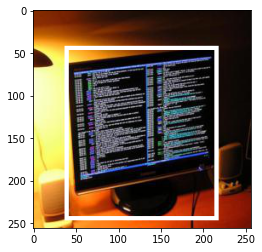

In [169]:
result = np.transpose(result, (1,2,0))
plt.imshow(result)